## Notebook for Running Experiments on CovType Data Set

In [1]:
from typing import List
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import nannyml as nml
from test_harness.datasets.dataset import Dataset

from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

In [3]:
from  test_harness.experiments.dde_experiment import DDEffectExperiment
from test_harness.experiments.baseline_experiment import BaselineExperiment

## Load Data

In [4]:
cicids_full_df = pd.read_csv("../data/cic_0.01km.csv")

In [5]:
cicids_full_df.head()

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Labelb
0,50833,0,0,0.0,0,0,50833.0,50833,0,32,32,19.672260,19.672260,0,1,1,319,153,32,0
1,49,0,0,0.0,0,0,49.0,49,49,64,0,40816.326530,0.000000,0,0,0,277,-1,32,0
2,306,6,6,6.0,6,6,306.0,306,0,20,20,3267.973856,3267.973856,6,0,1,0,0,20,0
3,63041,65,65,65.0,124,124,63041.0,63041,0,32,32,15.862693,15.862693,65,0,1,-1,-1,32,0
4,47682,43,43,43.0,59,59,47682.0,47682,0,32,32,20.972275,20.972275,43,0,1,-1,-1,32,0


In [6]:
cat_features_cicids = []

In [7]:
numeric_features_cicids = cicids_full_df.columns

In [8]:
# model_cicids = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
# param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3737
           1       1.00      0.95      0.97      1924

    accuracy                           0.98      5661
   macro avg       0.99      0.98      0.98      5661
weighted avg       0.98      0.98      0.98      5661

Accuracy: 0.9828652181593358


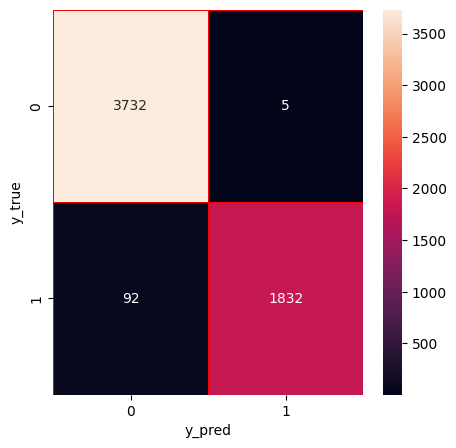

In [9]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = cicids_full_df.drop(['Labelb'],axis=1)
y = cicids_full_df['Labelb']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, shuffle=False,random_state = 0)

# # LightGBM algorithm
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [10]:
top_feats_df = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns.tolist()}).sort_values(by="Value",ascending=False)

In [11]:
top_feats = top_feats_df[top_feats_df['Value']>10].Feature.tolist()

In [12]:
cicids_full_df_reduced = cicids_full_df[top_feats]

In [13]:
column_mapping_adult = {
    "target": "Labelb",
    "numerical_features": cicids_full_df_reduced.columns,
    "categorical_features": [],
}

In [14]:
CT_dataset_cicids = Dataset(
    full_df=cicids_full_df_reduced, column_mapping=column_mapping_adult, window_size=1500 * 2, reference_size=10000
)

d:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.reference_df['period'] = 'reference'
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.reference_df['sample_num'] = self.reference_df.index
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [15]:
# plt.figure(figsize=(12,10))
# sns.heatmap(CT_dataset_cicids.full_df.corr(), annot=True)
#
# plt.title('Dataset correlation map')
# plt.show()

## Run Experiments

In [16]:
def windowed_correlation(df, mode='expanding'):
    corr_dict = {}
    columns = df.columns
    n = len(columns)
    for i in range(n):
        for j in range(i+1, n):
            col1 = columns[i]
            col2 = columns[j]
            key = (col1, col2)

            if mode=='expanding':
                corr_dict[key] = df[col1].expanding(10).corr(df[col2])
            else:
                corr_dict[key] = df[col1].rolling(window=10).corr(df[col2])

            corr_dict[key] = corr_dict[key].fillna(0)

    return corr_dict

In [17]:
def plot_windowed_correlation(corr_dict, vertical_lines=None):
    plt.figure(figsize=(15,10))
    for (col1, col2), corr in corr_dict.items():
        plt.plot(corr, label=f"{col1} vs {col2}")

    if vertical_lines:
        [plt.axvline(x, color='gray', linestyle='--') for x in vertical_lines if x != 0]

    plt.legend(bbox_to_anchor=(1, 0.5))
    #labelLines(plt.gca().get_lines(), align=True)
    plt.show()

In [18]:
corr_dict = windowed_correlation(CT_dataset_cicids.full_df.loc[:, CT_dataset_cicids.full_df.columns], mode='expanding')

In [19]:
#plot_windowed_correlation(corr_dict)

In [20]:
column_names = list(CT_dataset_cicids.reference_df.columns)

In [107]:
drift_detector = 'kolmogorov_smirnov'

In [108]:
calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    #timestamp_column_name='sample_num',
    continuous_methods=[drift_detector],
    categorical_methods=['jensen_shannon'],
    #chunk_number=10,
    chunk_size=100,
)

calc.fit(CT_dataset_cicids.reference_df)

In [109]:
results = calc.calculate(CT_dataset_cicids.analysis_df)

In [110]:
results_js = results.filter(column_names=results.continuous_column_names, methods=[drift_detector]).to_df()
results_js.columns = ['_'.join(col) for col in results_js.columns.values]
display(results_js)

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,Init_Win_bytes_forward_kolmogorov_smirnov_value,Init_Win_bytes_forward_kolmogorov_smirnov_upper_threshold,Init_Win_bytes_forward_kolmogorov_smirnov_lower_threshold,...,Bwd Packet Length Min_kolmogorov_smirnov_lower_threshold,Bwd Packet Length Min_kolmogorov_smirnov_alert,Down/Up Ratio_kolmogorov_smirnov_value,Down/Up Ratio_kolmogorov_smirnov_upper_threshold,Down/Up Ratio_kolmogorov_smirnov_lower_threshold,Down/Up Ratio_kolmogorov_smirnov_alert,sample_num_kolmogorov_smirnov_value,sample_num_kolmogorov_smirnov_upper_threshold,sample_num_kolmogorov_smirnov_lower_threshold,sample_num_kolmogorov_smirnov_alert
0,[0:99],0,0,99,None,None,analysis,0.163328,None,None,...,None,True,0.096235,None,None,False,0.9999,None,None,True
1,[100:199],1,100,199,None,None,analysis,0.078121,None,None,...,None,False,0.116235,None,None,False,1.0000,None,None,True
2,[200:299],2,200,299,None,None,analysis,0.191633,None,None,...,None,True,0.116235,None,None,False,1.0000,None,None,True
3,[300:399],3,300,399,None,None,analysis,0.213328,None,None,...,None,True,0.096235,None,None,False,1.0000,None,None,True
4,[400:499],4,400,499,None,None,analysis,0.242152,None,None,...,None,True,0.056235,None,None,False,1.0000,None,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,[17800:17899],178,17800,17899,None,None,analysis,0.357529,None,None,...,None,True,0.123765,None,None,False,1.0000,None,None,True
179,[17900:17999],179,17900,17999,None,None,analysis,0.363852,None,None,...,None,True,0.173765,None,None,True,1.0000,None,None,True
180,[18000:18099],180,18000,18099,None,None,analysis,0.449831,None,None,...,None,True,0.163765,None,None,True,1.0000,None,None,True
181,[18100:18199],181,18100,18199,None,None,analysis,0.387633,None,None,...,None,True,0.233765,None,None,True,1.0000,None,None,True


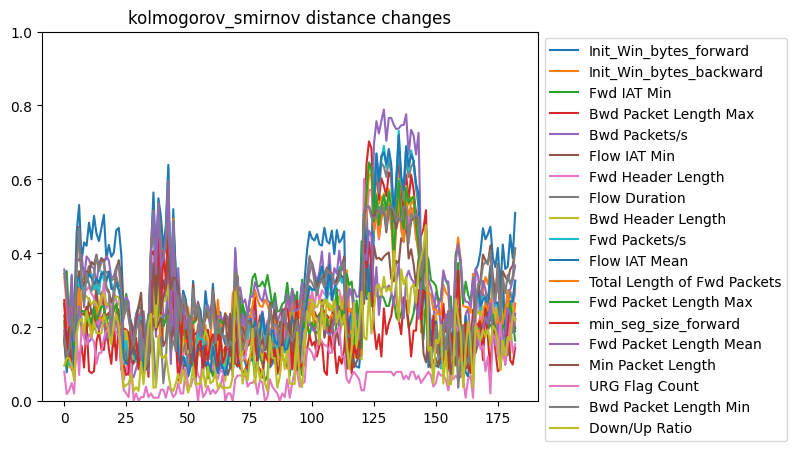

In [111]:
plot_df = results_js[[col for col in results_js.columns if f'_{drift_detector}_value' in col]]
plot_df.columns = [col.replace(f"_{drift_detector}_value", "") for col in plot_df.columns]

plot_df = plot_df.drop(columns=['sample_num'])

plot_df.plot(ylim=[0,1], )
plt.legend(bbox_to_anchor=(1, 1))
plt.title(f'{drift_detector} distance changes')
plt.show()

In [112]:
plot_df

,Init_Win_bytes_forward,Init_Win_bytes_backward,Fwd IAT Min,Bwd Packet Length Max,Bwd Packets/s,Flow IAT Min,Fwd Header Length,Flow Duration,Bwd Header Length,Fwd Packets/s,Flow IAT Mean,Total Length of Fwd Packets,Fwd Packet Length Max,min_seg_size_forward,Fwd Packet Length Mean,Min Packet Length,URG Flag Count,Bwd Packet Length Min,Down/Up Ratio
0,0.163328,0.155842,0.215854,0.263655,0.177470,0.231545,0.179433,0.189173,0.173951,0.159162,0.167663,0.337253,0.344154,0.273453,0.356248,0.165327,0.079192,0.172828,0.096235
1,0.078121,0.122337,0.094309,0.185451,0.253357,0.172216,0.140129,0.176265,0.155720,0.194148,0.188547,0.256155,0.352045,0.130739,0.280952,0.108818,0.019192,0.125448,0.116235
2,0.191633,0.195842,0.133931,0.103352,0.177971,0.144624,0.124883,0.119575,0.090759,0.097863,0.135467,0.174657,0.207153,0.200739,0.203654,0.118427,0.029192,0.139525,0.116235
3,0.213328,0.215842,0.219656,0.273155,0.223168,0.157837,0.108853,0.208660,0.170759,0.209460,0.215459,0.315753,0.337153,0.085790,0.341953,0.227923,0.049192,0.232328,0.096235
4,0.242152,0.145842,0.139656,0.104079,0.104285,0.075746,0.090360,0.107058,0.120970,0.090547,0.093637,0.164142,0.152954,0.075790,0.161953,0.206544,0.020808,0.179528,0.056235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.357529,0.255842,0.137565,0.165874,0.195348,0.181545,0.160360,0.183561,0.200970,0.155858,0.176060,0.244142,0.197163,0.098839,0.183448,0.336544,0.100808,0.291727,0.123765
179,0.363852,0.195842,0.123976,0.170375,0.298451,0.205156,0.210360,0.242960,0.280759,0.217261,0.220760,0.300141,0.212554,0.250739,0.251347,0.324028,0.150808,0.341727,0.173765
180,0.449831,0.215842,0.217676,0.236871,0.301551,0.177837,0.220360,0.296759,0.263970,0.258539,0.270835,0.190141,0.263166,0.110739,0.235070,0.356544,0.210808,0.316928,0.163765
181,0.387633,0.255842,0.213976,0.186873,0.326738,0.231545,0.260360,0.270364,0.243970,0.273247,0.269651,0.194142,0.215564,0.098839,0.185249,0.366544,0.130808,0.336928,0.233765


In [113]:
# plot_df.to_excel('outputs/cicids/JS_dist_cicids.xlsx')

In [114]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
# figure.show()

In [115]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

### Own Jensen-Shannon

In [116]:
chg_points = [3500, 10000, 12000]

In [117]:
CT_dataset_cicids.add_changepoints(chg_points)

In [118]:
rad_left = 500
rad_right = 500

In [119]:
dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset_cicids)
dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=rad_left, radius_right=rad_right)
display(dde_exp_eq_radius.results_all)

3000 3500 4000
9500 10000 10500


d:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['period'] = 'reference'
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['sample_num'] = ref_df.index
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

11500 12000 12500


d:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['period'] = 'reference'
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['sample_num'] = ref_df.index
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,start,change_point,end,Init_Win_bytes_forward,Init_Win_bytes_backward,Fwd IAT Min,Bwd Packet Length Max,Bwd Packets/s,Flow IAT Min,Fwd Header Length,...,Flow IAT Mean,Total Length of Fwd Packets,Fwd Packet Length Max,min_seg_size_forward,Fwd Packet Length Mean,Min Packet Length,URG Flag Count,Bwd Packet Length Min,Down/Up Ratio,sample_num
0,3000,3500,4000,0.622063,0.262135,0.250770,0.109915,0.091678,0.089419,0.526466,...,0.103827,0.084525,0.613267,0.623582,0.100263,0.551775,0.070690,0.258648,0.112505,0.996436
1,9500,10000,10500,0.208582,0.177987,0.118216,0.092878,0.120508,0.121227,0.031603,...,0.144694,0.073372,0.082726,0.033437,0.092513,0.223234,0.085502,0.132541,0.064633,0.996436
2,11500,12000,12500,0.122238,0.104361,0.315931,0.134571,0.088551,0.072431,0.214333,...,0.157744,0.093860,0.120618,0.081871,0.060663,0.210318,0.045512,0.081001,0.055540,0.996436


In [120]:
dde_exp_eq_radius.changepoint_radius_corr(radius_left=rad_left, radius_right=rad_right)

3000 3500 4000
9500 10000 10500
11500 12000 12500


In [148]:
with pd.ExcelWriter(f'measurements/final/monitored/cicids/monitored_KS.xlsx') as writer:

    for chp in CT_dataset_cicids.change_points[:1]:
        drift_threshold = 0.1
        summary_df = pd.DataFrame(columns=['feat_1', 'feat_2', 'ref_corr', 'analysis_corr', 'corr_delta', 'feat_1_cd_score', 'feat_2_cd_score', 'delta_cd_score'])

        corr_df_delta = dde_exp_eq_radius.corr_scores[chp]['corr_delta']
        corr_df_analysis = dde_exp_eq_radius.corr_scores[chp]['analysis']
        corr_df_ref = dde_exp_eq_radius.corr_scores[chp]['reference']

        cd_score_df = dde_exp_eq_radius.results_all.loc[dde_exp_eq_radius.results_all['change_point']==chp].iloc[0]

        for pair in itertools.combinations(dde_exp_eq_radius.dataset.full_df.columns, 2):
            feat1 = list(pair)[0]
            feat2 = list(pair)[1]

            summary_df.loc[len(summary_df.index)] = [feat1, feat2, np.abs(corr_df_ref.loc[feat1, feat2]), np.abs(corr_df_analysis.loc[feat1, feat2]), corr_df_delta.loc[feat1, feat2], cd_score_df[feat1], cd_score_df[feat2], np.abs(cd_score_df[feat1]-cd_score_df[feat2])]

        summary_df['feat_1_drift'] = np.where(summary_df['feat_1_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_2_drift'] = np.where(summary_df['feat_2_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_pair_drift'] = np.where(summary_df['feat_1_drift'] & summary_df['feat_2_drift'], 1, 0)

        summary_df.to_excel(writer, sheet_name=f'{chp}', index=False)

In [149]:
summary_df = summary_df.sort_values(by=['corr_delta'], ascending=False)

In [150]:
summary_df

,feat_1,feat_2,ref_corr,analysis_corr,corr_delta,feat_1_cd_score,feat_2_cd_score,delta_cd_score,feat_1_drift,feat_2_drift,feat_pair_drift
12,Init_Win_bytes_forward,min_seg_size_forward,0.018838,0.980634,0.999472,0.622063,0.623582,0.001519,1,1,1
119,Bwd Header Length,Fwd Packet Length Max,0.118006,0.964522,0.846516,0.213832,0.613267,0.399435,1,1,1
98,Fwd Header Length,Fwd Packet Length Max,0.140661,0.960199,0.819538,0.526466,0.613267,0.086800,1,1,1
161,Fwd Packet Length Mean,Min Packet Length,0.103202,0.860267,0.757065,0.100263,0.551775,0.451513,1,1,1
163,Fwd Packet Length Mean,Bwd Packet Length Min,0.083887,0.799795,0.715908,0.100263,0.258648,0.158385,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
21,Init_Win_bytes_backward,Flow IAT Min,0.008981,0.007030,0.001950,0.262135,0.089419,0.172716,1,0,0
43,Fwd IAT Min,Total Length of Fwd Packets,0.001528,0.003406,0.001878,0.250770,0.084525,0.166245,1,0,0
48,Fwd IAT Min,URG Flag Count,0.003886,0.002831,0.001055,0.250770,0.070690,0.180080,1,0,0
18,Init_Win_bytes_backward,Fwd IAT Min,0.003807,0.004513,0.000705,0.262135,0.250770,0.011365,1,1,1


In [151]:
summary_df.feat_pair_drift.sum()

91

In [152]:
def get_roc_auc(scores, ys):
    # false positive rate
    FPR = []
    # true positive rate
    TPR = []
    # Iterate thresholds from 0.0 to 1.0
    thresholds = np.arange(0.0, 1.01, 0.2)
    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

    # get number of positive and negative examples in the dataset
    P = sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for thresh in thresholds:
        FP=0
        TP=0
        thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
        for i in range(len(score)):
            if (score[i] >= thresh):
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP/N)
        TPR.append(TP/P)

    auc = -1 * np.trapz(TPR, FPR)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%auc)
    plt.legend(loc="lower right")
    plt.savefig('AUC_example.png')
    plt.show()

In [153]:
score = summary_df.ref_corr #np.array([0.8, 0.6, 0.4, 0.2])
y = summary_df.feat_pair_drift #np.array([1,0,1,0])

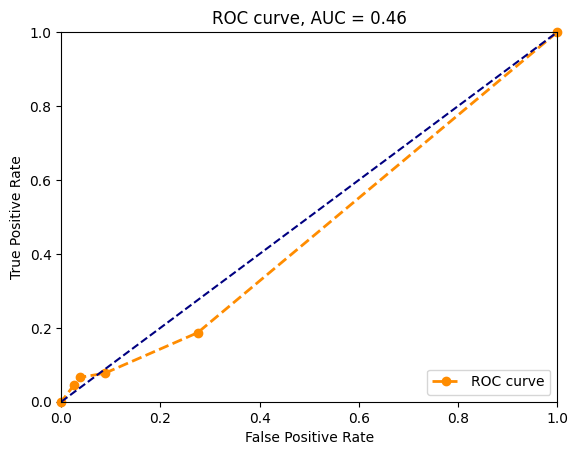

In [154]:
get_roc_auc(score, y)

In [103]:
def plot_lift_curve(y_pred, y_val, step=0.01, x_axis = 'number', gain_curve=False):

    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)

    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)

    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []

    fig, axis = plt.subplots()
    fig.figsize = (40,40)

    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)

        if gain_curve:
            y_v.append(data_here['predicted'].sum() / aux_lift['predicted'].sum())
            axis.set_ylabel('Gain')
            plt.title('Gain Curve')
        else:
            y_v.append(ratio_ones_here / ratio_ones)
            axis.plot(x_val, np.ones(len(x_val)), 'k-')
            axis.set_ylabel('Lift')
            plt.title('Lift Curve')


   #Plot the figure
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    #axis.set_xlim([0, len(y_val)])

    if x_axis == 'number':
        labels = [item.get_text() for item in axis.get_xticklabels()]
        labels = [int(float(i.replace('−', '-')) * len(y)) for i in labels[:-1]]
        #print(labels)
        axis.set_xticklabels(labels)
        axis.set_xlabel('Number of sample')

    else:
        axis.set_xlabel('Proportion of sample')

    plt.show()

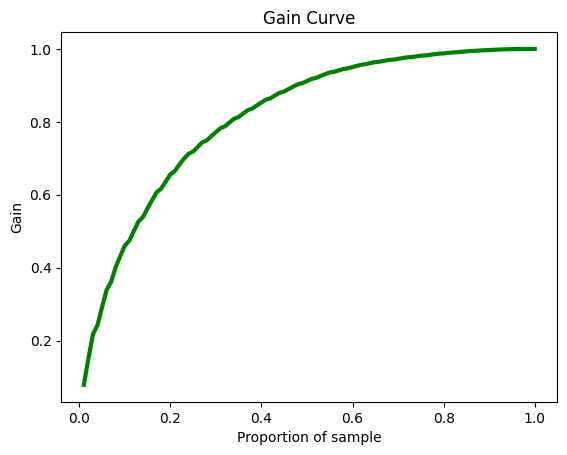

In [106]:
plot_lift_curve(score, y, x_axis='proportion', gain_curve=True)

In [ ]:
plot_lift_curve(score, y, x_axis='proportion', gain_curve=False)